<a href="https://colab.research.google.com/github/HedersonSantos/SmartHome/blob/main/seriesTemporais_sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

from sklearn.preprocessing import MinMaxScaler


from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # para determinar (p,q)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.theta import ThetaModel

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


In [ ]:
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/sample_submission.csv

In [ ]:
def plotaSeries(treino, teste, predito):
  if type(treino) == pd.core.series.Series:
    treino.plot(legend=True,label='Treino')
  if type(teste) == pd.core.series.Series:
    teste.plot(legend=True,label='Teste',figsize=(16,8))
  if  type(predito)==pd.core.series.Series:
    predito.plot(legend=True) 
  else:
    for p in predito.columns:
      predito[p].plot(legend=True)

In [ ]:
df_treino = pd.read_csv('train.csv')
df_treino['data_hora'] = df_treino.loc[:,['Date', 'Time']].apply(lambda x: datetime.strptime(x['Date'] + ' ' + x['Time'], '%d/%m/%Y %H:%M'), axis=1)
df_treino = df_treino.sort_values(by='data_hora')
df_treino = df_treino.set_index('data_hora')
idx = pd.date_range(start=df_treino.index.min(), end=df_treino.index.max(),  freq='0h15min')
df_treino= df_treino.reindex(idx)
df_treino.fillna(method='ffill', inplace=True)

In [ ]:
min(df_treino.index), max(df_treino.index)

In [ ]:
df_treino.info() 

In [ ]:
df_treino.groupby('Date')['Id'].count().reset_index().sort_values('Date')

In [ ]:
df_treino = df_treino[df_treino['Date']!="13/03/2012"]
df_treino = df_treino[df_treino['Date']!="11/04/2012"]

In [ ]:
df_treino.head(5)

In [ ]:
df_treino['umidade_interna'] = df_treino['Relative_humidity_room'].map(lambda x: x/2)

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(df_treino['Indoor_temperature_room'], color='red', label = 'indoor temperature room')
plt.plot(df_treino['Relative_humidity_room'], color='blue', label = 'relative humidity room')
plt.plot(df_treino['CO2_room'], color='green', label = 'CO2_room')
plt.plot(df_treino['Outdoor_relative_humidity_Sensor'], color='pink', label = 'Outdoor_relative_humidity_Sensor')
plt.plot(df_treino['Lighting_room'], color='orange', label = 'Outdoor_relative_humidity_Sensor')
plt.legend()
plt.show()



In [ ]:
df_treino.plot.scatter('umidade_interna','Indoor_temperature_room', figsize=(14,6))

In [ ]:
#dividindo a amostra em treino e teste
dfTreino = df_treino[df_treino.index < datetime(2012,4,8,0,0)]
dfTeste = df_treino[df_treino.index >= datetime(2012,4,8,0,0)]
print(dfTreino.shape, dfTeste.shape)
print(min(dfTreino.index), max(dfTreino.index))
print(min(dfTeste.index), max(dfTeste.index))

In [ ]:
scaler = MinMaxScaler()
dfTreino = scaler.fit_transform(dfTreino)
dfTeste = scaler.fit_transform(dfTeste)


In [15]:
from statsmodels.formula.api import ols

# Ajusta o modelo de regressão linear simples para Close com IBOV/1000 como preditora
modelo = ols('Indoor_temperature_room ~ Relative_humidity_room + CO2_room + Outdoor_relative_humidity_Sensor + Lighting_room',data=dfTreino)
res = modelo.fit()

# valores ajustados de E(Y)
ypred=res.fittedvalues

# resíduo=observado-ajustado
residuo = res.resid

In [16]:
'''from mpl_toolkits.mplot3d import Axes3D
sns.set(style = "darkgrid")

fig = plt.figure( figsize=(14,6))
ax = fig.add_subplot(111, projection = '3d')

x = df_treino['Indoor_temperature_room']
y = df_treino['Relative_humidity_room']
z = df_treino['CO2_room']

ax.set_xlabel("Indoor_temperature_room")
ax.set_ylabel("Relative_humidity_room")
ax.set_zlabel("CO2_room")

ax.scatter(x, y, z)

plt.show()
'''

'from mpl_toolkits.mplot3d import Axes3D\nsns.set(style = "darkgrid")\n\nfig = plt.figure( figsize=(14,6))\nax = fig.add_subplot(111, projection = \'3d\')\n\nx = df_treino[\'Indoor_temperature_room\']\ny = df_treino[\'Relative_humidity_room\']\nz = df_treino[\'CO2_room\']\n\nax.set_xlabel("Indoor_temperature_room")\nax.set_ylabel("Relative_humidity_room")\nax.set_zlabel("CO2_room")\n\nax.scatter(x, y, z)\n\nplt.show()\n'

No handles with labels found to put in legend.


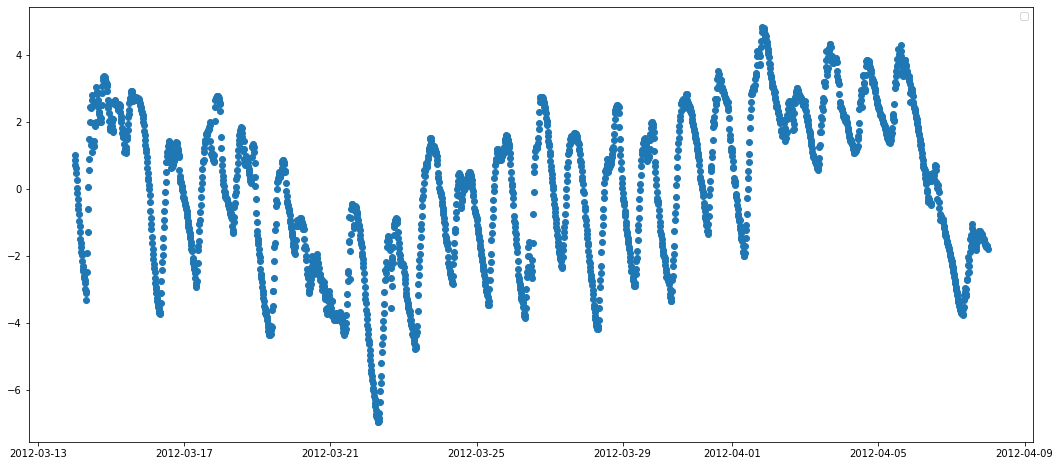

In [17]:
fig, ax = plt.subplots(figsize=(18,8))
plt.scatter(residuo.index,residuo)
plt.legend()
plt.show()

No handles with labels found to put in legend.


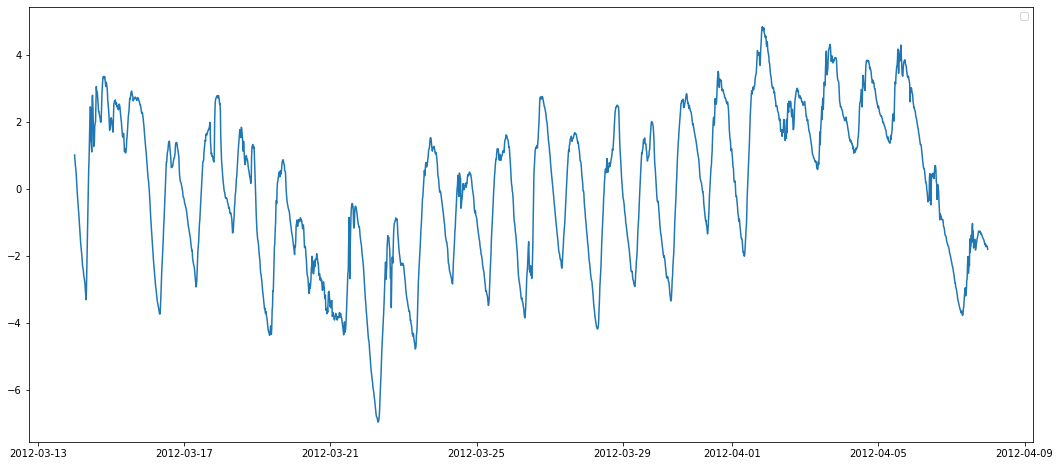

In [18]:
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(residuo)
plt.legend()
plt.show()

In [19]:
stepwise_fit = auto_arima(residuo, start_p=2, start_q=2,
                          max_p=2, max_q=2, m=96,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic


KeyboardInterrupt: ignored

In [ ]:
endog = dfTreino['umidade_interna']
exog = dfTreino['Indoor_temperature_room']

In [ ]:
import statsmodels.api as sm

modelo = sm.tsa.statespace.SARIMAX(endog, exog, order=(2,1,0) ,seasonal_order=(1,0,1,96))
resultado = modelo.fit(disp=False)
print(resultado.summary())

In [ ]:
start=len(dfTreino)
end=len(dfTreino)+len(dfTeste)-1
exog_forecast = dfTeste[['Indoor_temperature_room']]  
previsao = resultado.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX')

In [ ]:
dfTeste['SARIMAX']=previsao

In [ ]:
plotaSeries(None, dfTeste['Indoor_temperature_room'], dfTeste['SARIMAX'])